## Load datasets

In [1]:
import pandas as pd
import os

sample_size = 7500

dfs_train = {}
dfs_val = {}
for file in os.listdir("vectorized_data"):
    if file.endswith("train.csv"):
        df = pd.read_csv("vectorized_data/" + file, index_col=0)
        key = file.split("_")[-2]
        if sample_size < df.shape[0]:
            dfs_train[key] = df.sample(sample_size)
        else:
            dfs_train[key] = df
    elif file.endswith("val.csv"):
        df = pd.read_csv("vectorized_data/" + file, index_col=0)
        key = file.split("_")[-2]
        if sample_size < df.shape[0]:
            dfs_val[key] = df.sample(sample_size)
        else:
            dfs_val[key] = df

for key in dfs_train:
    dfs_train[key] = {
        'label': dfs_train[key]["category1"],
        'data': dfs_train[key].drop(columns=["category1"])
    }

    print(f"DFs train {key} (data):{dfs_train[key]['data'].shape}")

for key in dfs_val:
    dfs_val[key] = {
        'label': dfs_val[key]["category1"],
        'data': dfs_val[key].drop(columns=["category1"])
    }

    print(f"DFs validation {key} (data):{dfs_val[key]['data'].shape}")

DFs train 0.025 (data):(7500, 138)
DFs train 0.05 (data):(7500, 54)
DFs train 0.1 (data):(7500, 19)
DFs train 0.01 (data):(7500, 377)
DFs train 0.075 (data):(7500, 30)
DFs validation 0.05 (data):(7500, 54)
DFs validation 0.1 (data):(7500, 19)
DFs validation 0.075 (data):(7500, 30)
DFs validation 0.01 (data):(7500, 377)
DFs validation 0.025 (data):(7500, 138)


## Evaluate accuracy with k-NN

### Determine best vectorizer min_df value

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_classification_single(knn, data, data_class):
    y_pred = knn.predict(data)
    return accuracy_score(data_class, y_pred)

def evaluate_classification_dataset(df_train, df_val, n_neighbors):
    accuracy_train = []
    accuracy_val = []
    for k in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        knn.fit(df_train['data'], df_train['label'])
        accuracy_train.append(evaluate_classification_single(knn, df_train['data'], df_train['label']))
        accuracy_val.append(evaluate_classification_single(knn, df_val['data'], df_val['label']))
    return accuracy_train, accuracy_val



In [3]:
n_neighbors = [2, 5, 10, 15, 20, 25]
# n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]
accuracies = {}

for key in dfs_train:
    print(f'Evaluating dataset {key}')
    acc_train, acc_val = evaluate_classification_dataset(dfs_train[key], dfs_val[key], n_neighbors)
    accuracies[key] = {
        'train': acc_train,
        'val': acc_val
    }

Evaluating dataset 0.025
Evaluating dataset 0.05
Evaluating dataset 0.1
Evaluating dataset 0.01
Evaluating dataset 0.075


In [4]:
def plot_accuracy(accuracies, n_neighbors):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))

    for key in accuracies:
        plt.subplot(1, 2, 1)
        plt.plot(n_neighbors, accuracies[key]['train'], label=f'Train {key}')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Accuracy')
        plt.title('Train Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(n_neighbors, accuracies[key]['val'], label=f'Validation {key}')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

    plt.show()

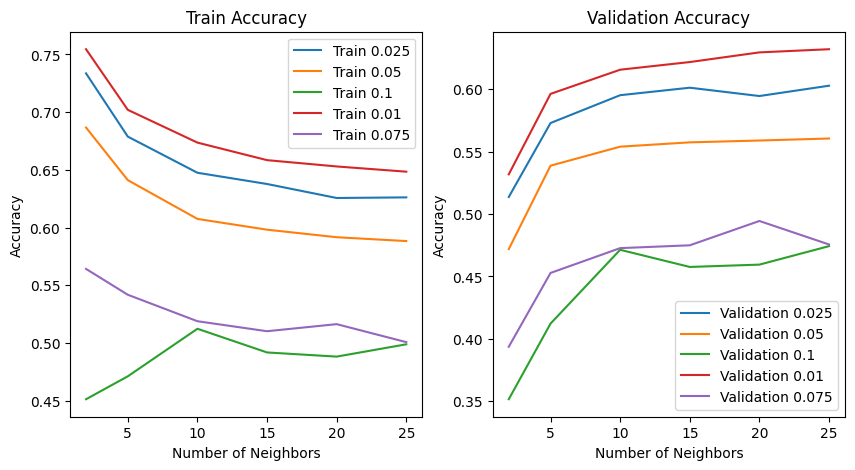

In [5]:
plot_accuracy(accuracies, n_neighbors)

### Create reduced datasets

In [6]:
# Based on the plot, we can see that the best value for min_df is:
min_df_val = '0.01'

#### Correlation

In [7]:
def calculateMeanAbsCorrelation(df):
    return df.corr().abs().mean()

def selectLowestCorrelationFeatures(df, num_features):
    mean_abs_correlation = calculateMeanAbsCorrelation(df)
    mean_abs_correlation.sort_values(ascending=True, inplace=True)
    mean_abs_correlation = mean_abs_correlation[:num_features]
    list_of_features = mean_abs_correlation.index.tolist()
    return list_of_features, df[list_of_features]

In [8]:
list_of_features, df = selectLowestCorrelationFeatures(dfs_train[min_df_val]['data'], 3)
print(f'Features: {list_of_features}')
dfs_train_corr3 = {
    'label': dfs_train[min_df_val]['label'],
    'data': df,
    'features': list_of_features
}

list_of_features, df = selectLowestCorrelationFeatures(dfs_train[min_df_val]['data'], 9)
print(f'Features: {list_of_features}')
dfs_train_corr9 = {
    'label': dfs_train[min_df_val]['label'],
    'data': df,
    'features': list_of_features
}

dfs_train_corr = {
    '3': dfs_train_corr3,
    '9': dfs_train_corr9
}

dfs_val_corr = {
    '3': {
        'label': dfs_val[min_df_val]['label'],
        'data': dfs_val[min_df_val]['data'][dfs_train_corr3['features']]
    },
    '9': {
        'label': dfs_val[min_df_val]['label'],
        'data': dfs_val[min_df_val]['data'][dfs_train_corr9['features']]
    }
}

Features: ['devido', 'aplicativo', 'pedir']
Features: ['devido', 'aplicativo', 'pedir', 'caixa', 'dar', 'pessoal', 'urgente', 'envio', 'usar']


#### PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, whiten=True).fit(dfs_train[min_df_val]['data'])
print(f'PCA components: {pca.n_components_}')
dfs_train_pca3 = {
    'label': dfs_train[min_df_val]['label'],
    'data': pca.transform(dfs_train[min_df_val]['data']),
    'pca': pca
}

pca = PCA(n_components=0.9, whiten=True).fit(dfs_train[min_df_val]['data'])
print(f'PCA components: {pca.n_components_}')
dfs_train_pca90 = {
    'label': dfs_train[min_df_val]['label'],
    'data': pca.transform(dfs_train[min_df_val]['data']),
    'pca': pca
}

dfs_train_pca = {
    '3': dfs_train_pca3,
    '90': dfs_train_pca90
}

dfs_val_pca = {
    '3': {
        'label': dfs_val[min_df_val]['label'],
        'data': dfs_train_pca3['pca'].transform(dfs_val[min_df_val]['data'])
    },
    '90': {
        'label': dfs_val[min_df_val]['label'],
        'data': dfs_train_pca90['pca'].transform(dfs_val[min_df_val]['data'])
    }
}

PCA components: 3
PCA components: 246


### Select the most accurate dataset for each reduction method

Correlation
Evaluating dataset 3
Correlation
Evaluating dataset 9
PCA
Evaluating dataset 3
PCA
Evaluating dataset 90


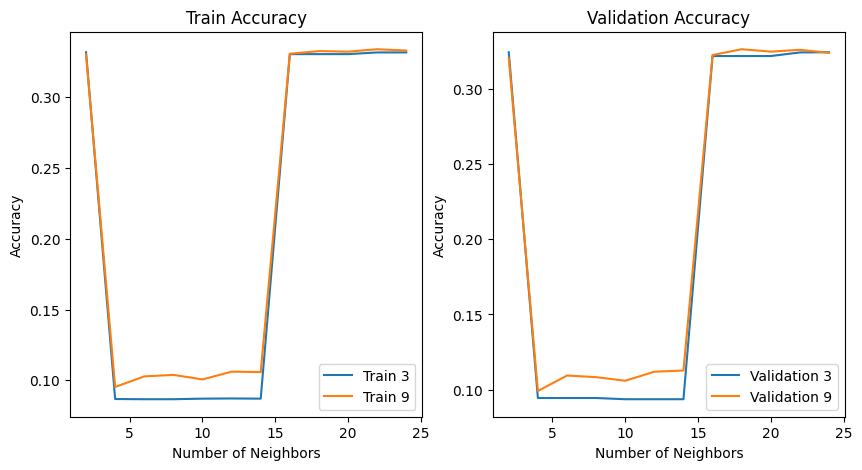

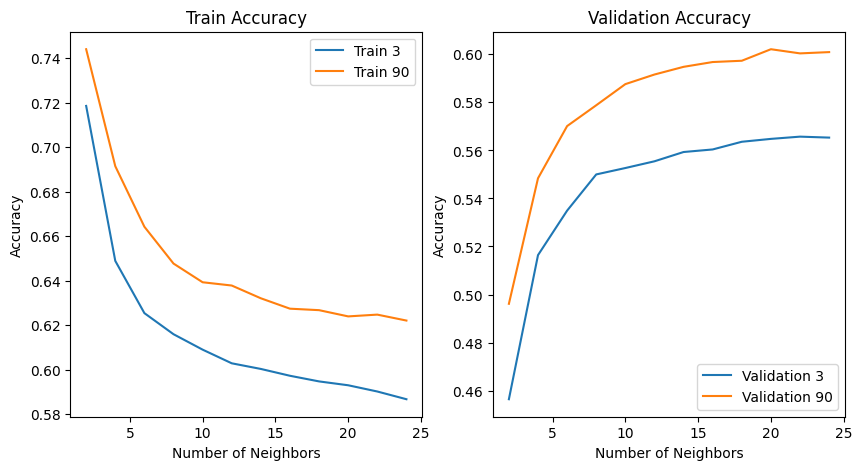

In [38]:
accuracies_corr = {}
accuracies_pca = {}

n_neighbors = list(range(2, 26, 2))

for key in dfs_train_corr:
    print('Correlation')
    print(f'Evaluating dataset {key}')
    acc_train, acc_val = evaluate_classification_dataset(dfs_train_corr[key], dfs_val_corr[key], n_neighbors)
    accuracies_corr[key] = {
        'train': acc_train,
        'val': acc_val
    }

for key in dfs_train_pca:
    print('PCA')
    print(f'Evaluating dataset {key}')
    acc_train, acc_val = evaluate_classification_dataset(dfs_train_pca[key], dfs_val_pca[key], n_neighbors)
    accuracies_pca[key] = {
        'train': acc_train,
        'val': acc_val
    }

plot_accuracy(accuracies_corr, n_neighbors)
plot_accuracy(accuracies_pca, n_neighbors)

In [39]:
best_dfs_train = {
    'corr' : dfs_train_corr['3'],
    'pca' : dfs_train_pca['90'],
}

best_dfs_val = {
    'corr' : dfs_val_corr['3'],
    'pca' : dfs_val_pca['90'],
}

### Evaluate the clustering methods

#### Parameters

In [12]:
number_clusters = [2, 5, 10, 15, 20, 25]
list_train = [dfs_train[min_df_val]['data'], best_dfs_train['corr']['data'], best_dfs_train['pca']['data']]
list_labels = [dfs_train[min_df_val]['label'], best_dfs_train['corr']['label'], best_dfs_train['pca']['label']]
dbs_names = ['Original', 'Correlation 9', 'PCA 90%']

#### Define helper functions

In [13]:

from sklearn.metrics import davies_bouldin_score, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def evaluate_performance_single(data, labels, k, method):
    trained = method(data, k)

    y_pred = trained.fit_predict(data)

    return [davies_bouldin_score(data, y_pred), silhouette_score(data, y_pred), adjusted_rand_score(labels, y_pred)]

def evaluate_performance_method(dbs, labels, nclusters, method, dbs_names=[]):
    metrics = []
    i = 0
    len_dbs = len(dbs)
    for i in range(len_dbs):
      metrics_for_db = []
      for k in nclusters:
        metrics_for_db.append(evaluate_performance_single(dbs[i], labels[i], k, method))
      # print(metrics_for_db)
      metrics_for_db = list(zip(*metrics_for_db))
      # print(metrics_for_db)
      if dbs_names:
        metrics.append([dbs_names[i], metrics_for_db])
      else:
        metrics.append([f'db{i}', metrics_for_db])
      i += 1
    return metrics

def plot_results(results, number_clusters):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(len(results)):
      axs[0].plot(number_clusters, results[i][1][0], label=results[i][0])
    axs[0].set_xlim(number_clusters[0], number_clusters[-1])
    axs[0].legend()
    axs[0].set_xlabel('k')
    axs[0].set_ylabel('Davies-Bouldin Score')

    for i in range(len(results)):
      axs[1].plot(number_clusters, results[i][1][1], label=results[i][0])
    axs[1].set_xlim(number_clusters[0], number_clusters[-1])
    axs[1].legend()
    axs[1].set_xlabel('k')
    axs[1].set_ylabel('Silhouette Score')

    for i in range(len(results)):
      axs[2].plot(number_clusters, results[i][1][2], label=results[i][0])
    axs[2].set_xlim(number_clusters[0], number_clusters[-1])
    axs[2].legend()
    axs[2].set_xlabel('k')
    axs[2].set_ylabel('Adjusted Rand Score')

    plt.tight_layout()
    plt.show()

#### k-Means

In [14]:
def kmeans(dataset, n_clusters):
  from sklearn.cluster import KMeans

  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=300, max_iter=10)

  return kmeans

In [15]:
kmeans_results = evaluate_performance_method(
        list_train,
        list_labels,
        number_clusters,
        kmeans,
        dbs_names=dbs_names
    )

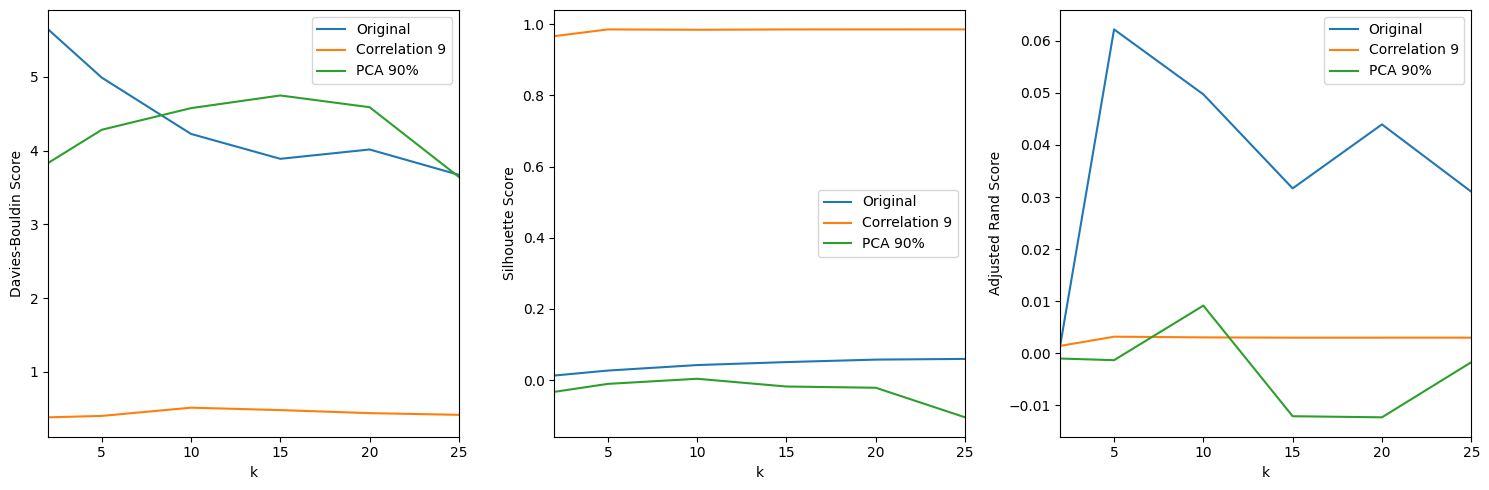

In [16]:
plot_results(kmeans_results, number_clusters)

#### Hierarchical

In [17]:
def hier_aglo(dataset, n_clusters):
  from sklearn.cluster import AgglomerativeClustering

  hier_aglo = AgglomerativeClustering(n_clusters, metric='euclidean', linkage='complete')

  return hier_aglo

In [18]:
hier_aglo_results = evaluate_performance_method(
        list_train,
        list_labels,
        number_clusters,
        hier_aglo,
        dbs_names=dbs_names
    )

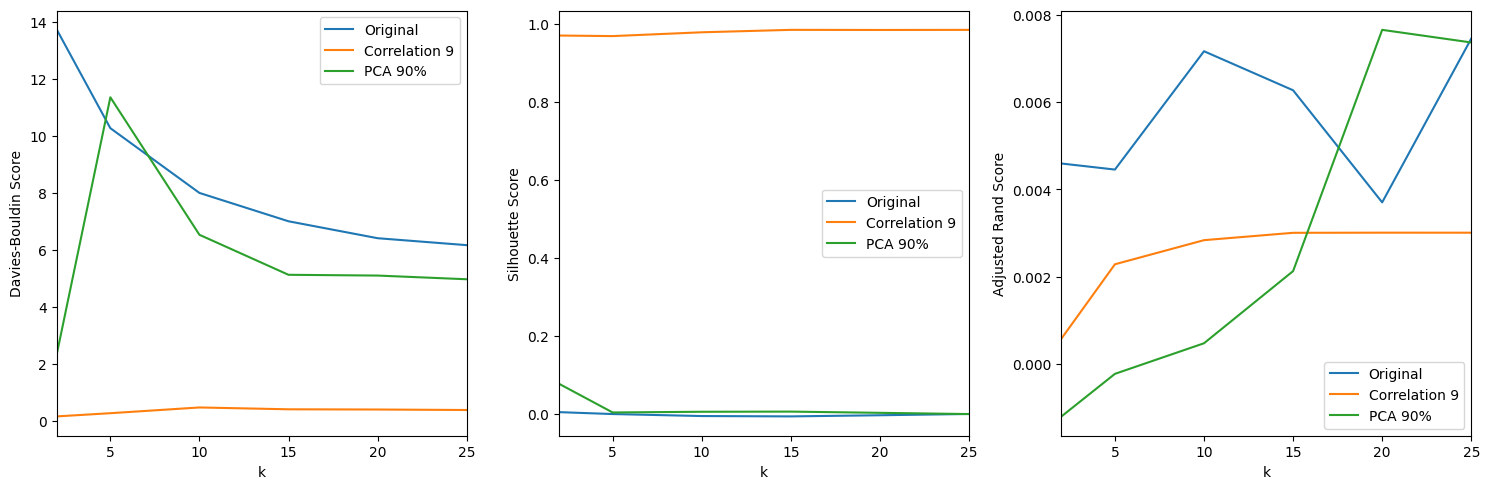

In [19]:
plot_results(hier_aglo_results, number_clusters)

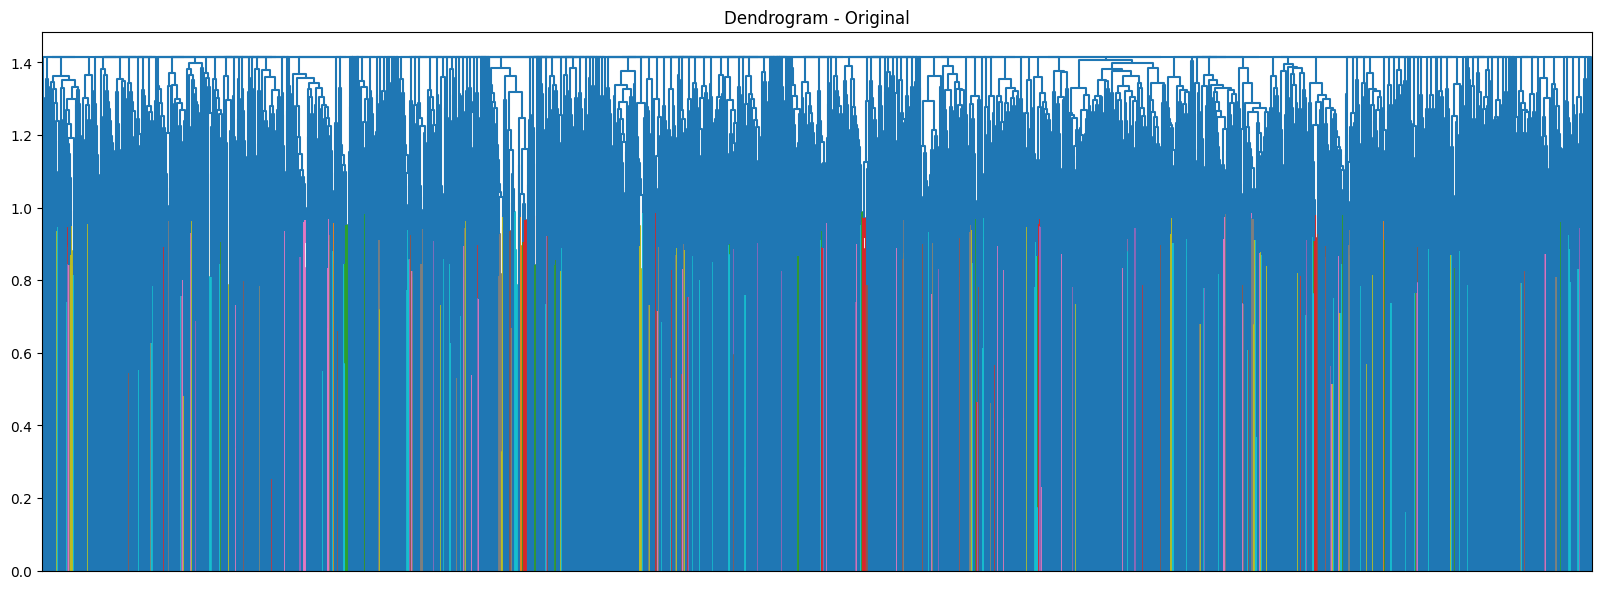

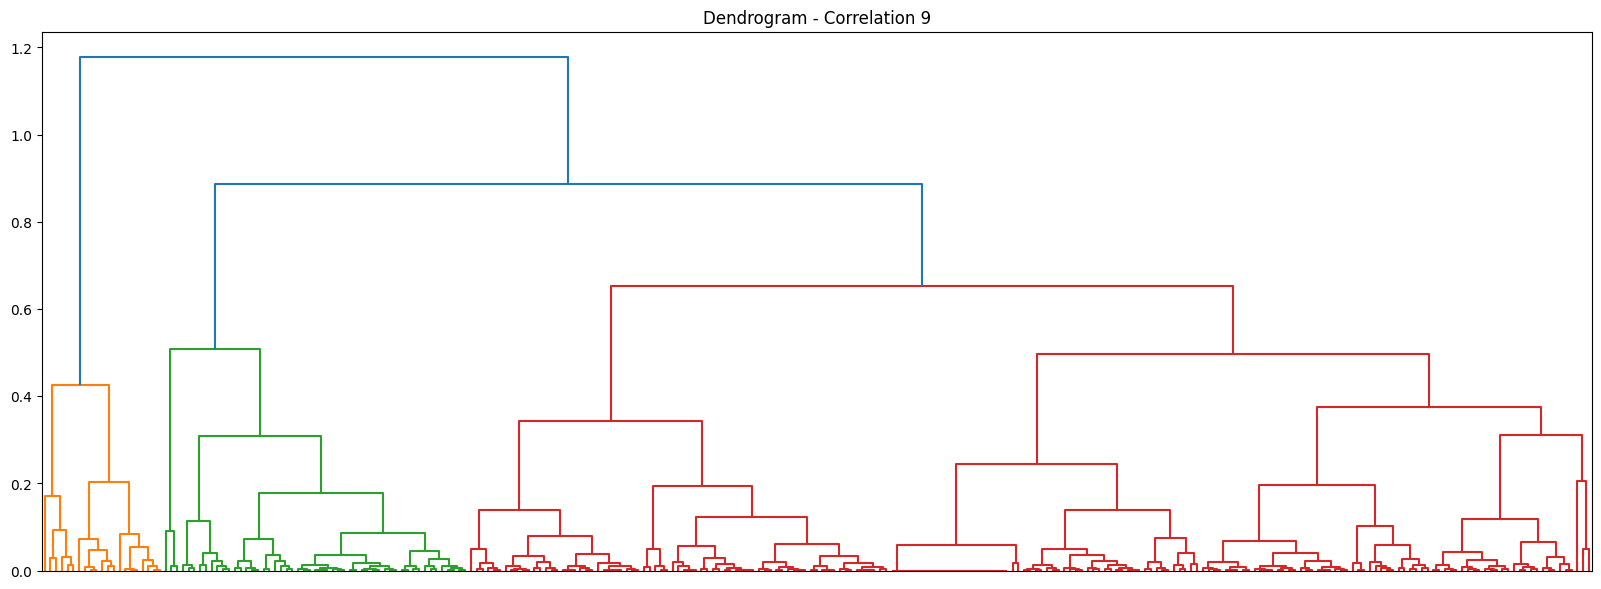

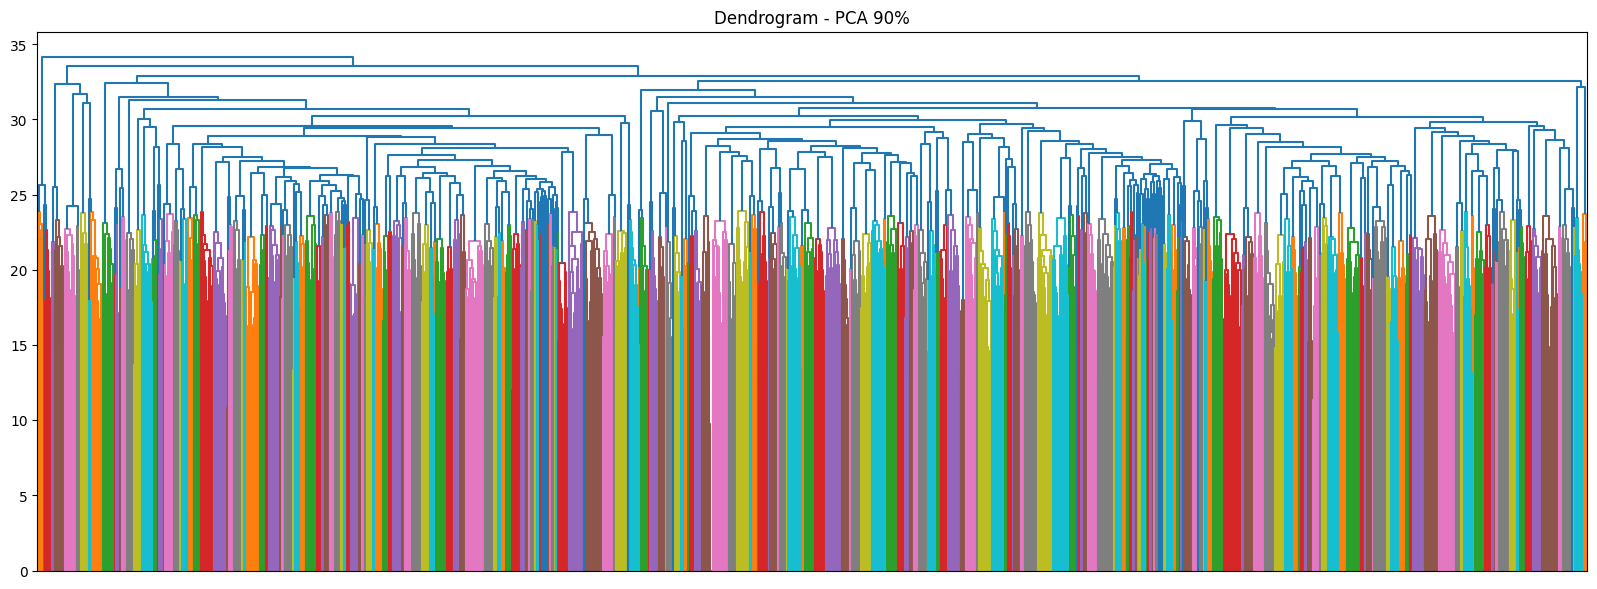

In [20]:
import scipy.cluster.hierarchy as shc

for i in range(len(list_train)):
    plt.figure(figsize=(20, 7))
    plt.title(f"Dendrogram - {dbs_names[i]}")
    # Added truncate_mode='level' to limit the depth of the dendrogram
    shc.dendrogram(shc.linkage(list_train[i], method='complete'), truncate_mode='level', p=25)
    plt.xticks([])  # Hide x-axis labels
    plt.show()


#### EM

In [21]:
def em(dataset, n_clusters):
  from sklearn.mixture import GaussianMixture

  em = GaussianMixture(n_components=n_clusters, covariance_type='full')

  return em

In [22]:
em_results = evaluate_performance_method(
        list_train,
        list_labels,
        number_clusters,
        em,
        dbs_names=['Original', 'Correlation 9', 'PCA 90%']
    )

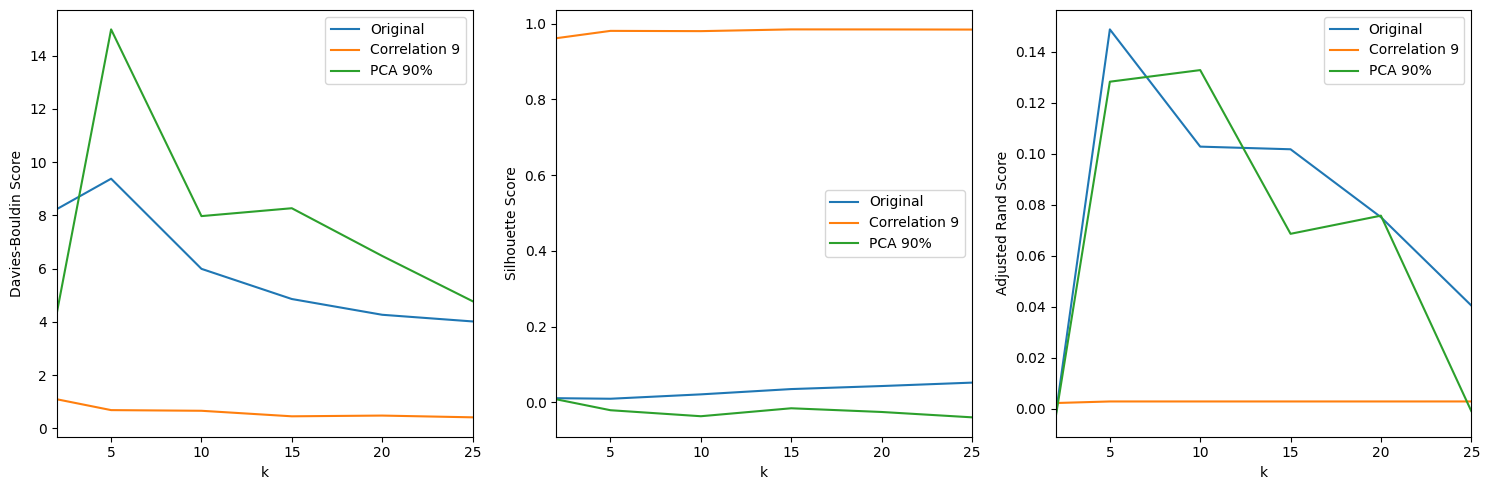

In [23]:
plot_results(em_results, number_clusters)

#### DBScan

In [24]:
def evaluate_performance_dbscan_single(data, labels, min_samples, eps):
    from sklearn.cluster import DBSCAN

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')

    y_pred = dbscan.fit_predict(data)

    return [davies_bouldin_score(data, y_pred), silhouette_score(data, y_pred, metric='euclidean'), adjusted_rand_score(labels, y_pred)]


def evaluate_performance_dbscan(data, labels, min_samples_values, dbs_names=[], eps_values=[]):
    metrics = []
    i = 0
    len_dbs = len(data)
    for i in range(len_dbs):
      for eps in eps_values:
        metrics_for_min_samples = []
        for min_samples in min_samples_values:
          metrics_for_min_samples.append(evaluate_performance_dbscan_single(data[i], labels[i], min_samples, eps))

        metrics_for_min_samples = list(zip(*metrics_for_min_samples))

        if dbs_names:
          metrics.append([f'{dbs_names[i]} - eps {eps}', metrics_for_min_samples])
        else:
          metrics.append([f'db{i}', metrics_for_min_samples])
      i += 1
    return metrics


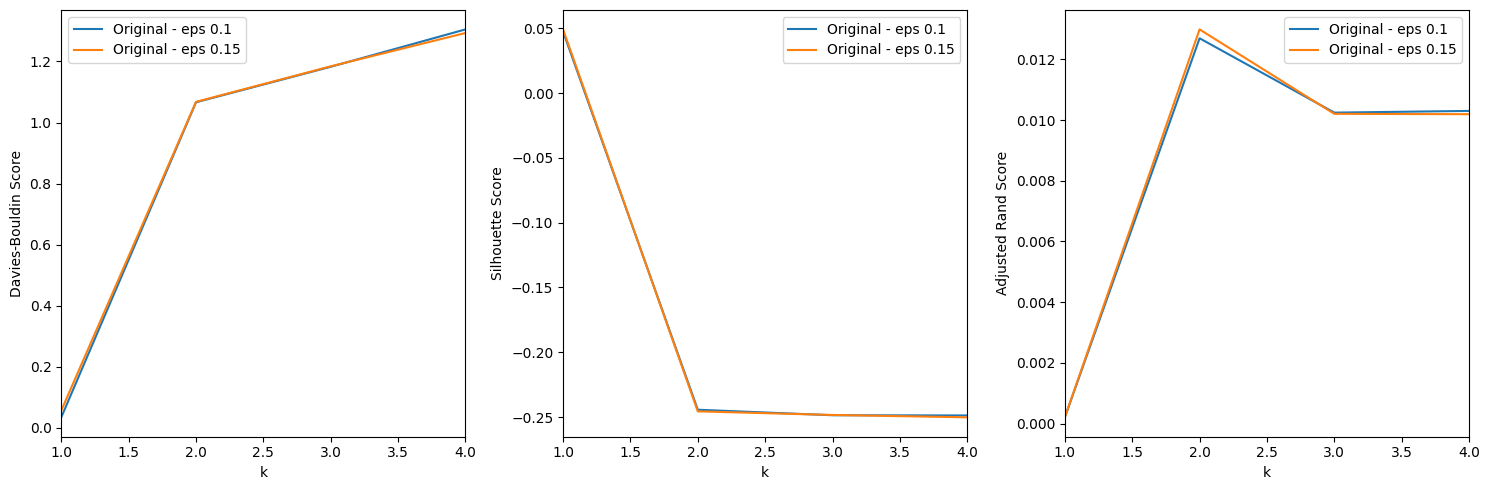

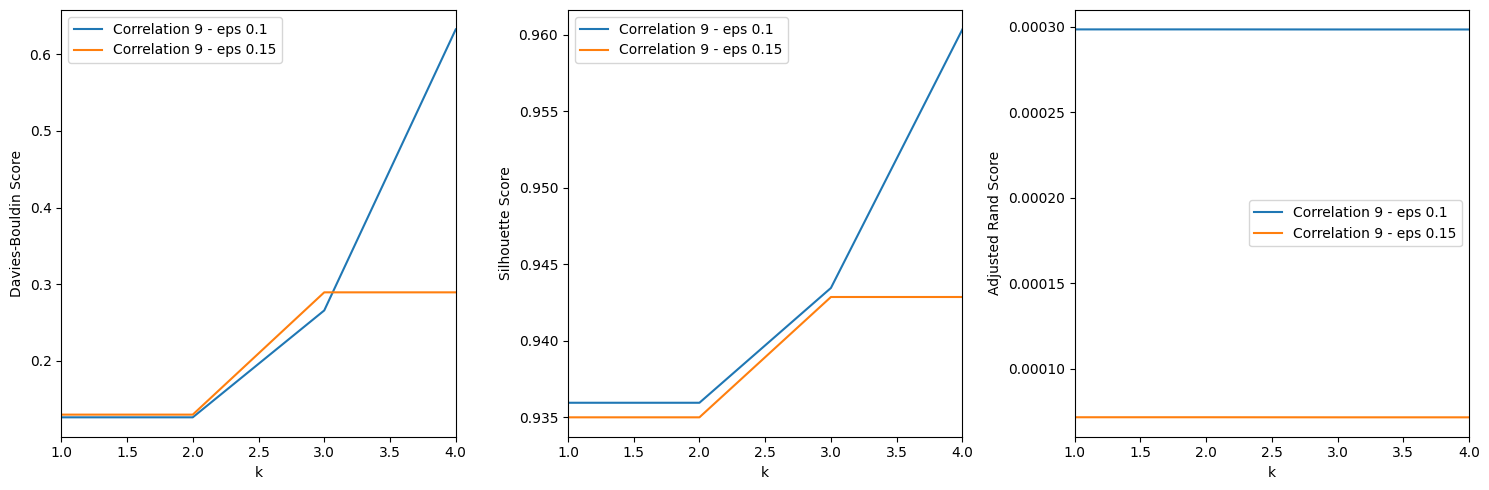

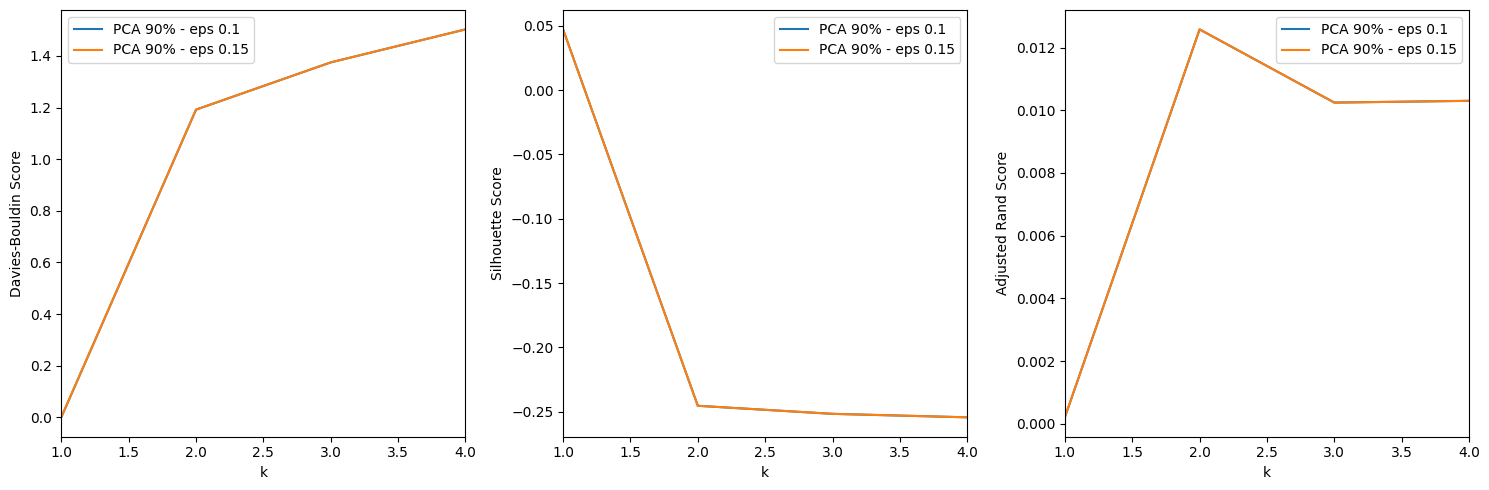

In [25]:
eps_values = [0.1, 0.15]
min_samples_values = [1, 2, 3, 4]

for i in range(len(list_train)):
    dbscan_results = evaluate_performance_dbscan(
        [list_train[i]],
        [list_labels[i]],
        min_samples_values,
        dbs_names=[dbs_names[i]],
        eps_values=eps_values
    )
    plot_results(dbscan_results, min_samples_values)

#### Clustering ensemble

In [26]:
def relabel_clustering_pair(reference_labels, other_labels):
    import numpy as np
    from sklearn.metrics import confusion_matrix
    from scipy.optimize import linear_sum_assignment
    """
    Relabel other_labels to match as closely as possible with reference_labels.
    """

    # Compute contingency matrix
    contingency_matrix = confusion_matrix(reference_labels, other_labels)

    # Solve the linear assignment problem to find the best label mapping
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # Create a mapping from old labels to new labels
    label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}

    # Relabel the clusters
    relabeled = np.array([label_mapping[label] for label in other_labels])
    return relabeled

def relabel_clusters(labels):
    """
    Relabel other_labels to match as closely as possible with reference_labels.
    The reference labels are the first label in the list.
    """
    labels = labels.copy()
    for i in range(1, len(labels)):
        labels[i] = relabel_clustering_pair(labels[0], labels[i])
    return labels

def compute_co_association_matrix(clusterings):
    import numpy as np
    """
    Computes the co-association matrix from multiple clustering results.

    Args:
    - clusterings (ndarray): Array of shape (n_clusterings, n_samples) containing cluster labels.

    Returns:
    - co_association_matrix (ndarray): Co-association matrix of shape (n_samples, n_samples).
    """
    n_clusterings, n_samples = clusterings.shape
    co_association_matrix = np.zeros((n_samples, n_samples))

    # Iterate through each pair of points
    for i in range(n_samples):
        for j in range(n_samples):
            # Count how many clusterings have the points in the same cluster
            co_association_matrix[i, j] = np.sum(clusterings[:, i] == clusterings[:, j])

    # Normalize by the number of clusterings
    co_association_matrix /= n_clusterings
    return co_association_matrix

def calculate_consensus_labels(clusterings, num_clusters):
    """
    Calculate consensus labels for a given set of clusterings.

    Args:
    - clusterings (list): List of clusterings.
    - num_clusters (int): Number of clusters.

    Returns:
    - consensus_labels (ndarray): Array of shape (n_samples,) containing consensus labels.
    """
    import numpy as np
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
    from scipy.spatial.distance import squareform

    clusterings_aligned = relabel_clusters(clusterings)

    co_association_matrix = compute_co_association_matrix(np.vstack(clusterings_aligned))

    # Convert the co-association matrix to a distance matrix
    distance_matrix = 1 - co_association_matrix

    # Perform hierarchical clustering
    linkage_matrix = linkage(squareform(distance_matrix), method='average')

    consensus_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    return consensus_labels


In [27]:
def ensemble_clustering(dataset, num_clusters):
    from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
    from sklearn.mixture import GaussianMixture

    clt_models = [
        KMeans(n_clusters=num_clusters, init='k-means++', n_init=300, max_iter=10),
        AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='complete'),
        GaussianMixture(n_components=num_clusters, covariance_type='full')
        # DBSCAN(eps=0.2, min_samples=3, metric='euclidean')
    ]

    clusterings = list(map(lambda x: x.fit_predict(dataset), clt_models))

    return calculate_consensus_labels(clusterings, num_clusters)

In [28]:
def evaluate_performance_ensemble_single(data, labels, clusters):
    from sklearn.metrics import davies_bouldin_score, adjusted_rand_score, silhouette_score
    print(f'Evaluating ensemble clustering with {clusters} clusters')
    y_pred = ensemble_clustering(data, clusters)

    return [davies_bouldin_score(data, y_pred), silhouette_score(data, y_pred, metric='euclidean'), adjusted_rand_score(labels, y_pred)]

def evaluate_performance_ensemble(dbs, labels, nclusters, dbs_names=[]):
    metrics = []
    i = 0
    len_dbs = len(dbs)
    for i in range(len_dbs):
      metrics_for_db = []
      for k in nclusters:
        metrics_for_db.append(evaluate_performance_ensemble_single(dbs[i], labels[i], k))
      # print(metrics_for_db)
      metrics_for_db = list(zip(*metrics_for_db))
      # print(metrics_for_db)
      if dbs_names:
        metrics.append([dbs_names[i], metrics_for_db])
      else:
        metrics.append([f'db{i}', metrics_for_db])
      i += 1
    return metrics

In [29]:
ensemble_results = evaluate_performance_ensemble(
        list_train,
        list_labels,
        number_clusters,
        dbs_names
)

Evaluating ensemble clustering with 2 clusters
Evaluating ensemble clustering with 5 clusters
Evaluating ensemble clustering with 10 clusters
Evaluating ensemble clustering with 15 clusters
Evaluating ensemble clustering with 20 clusters
Evaluating ensemble clustering with 25 clusters
Evaluating ensemble clustering with 2 clusters
Evaluating ensemble clustering with 5 clusters
Evaluating ensemble clustering with 10 clusters
Evaluating ensemble clustering with 15 clusters
Evaluating ensemble clustering with 20 clusters
Evaluating ensemble clustering with 25 clusters
Evaluating ensemble clustering with 2 clusters
Evaluating ensemble clustering with 5 clusters
Evaluating ensemble clustering with 10 clusters
Evaluating ensemble clustering with 15 clusters
Evaluating ensemble clustering with 20 clusters
Evaluating ensemble clustering with 25 clusters


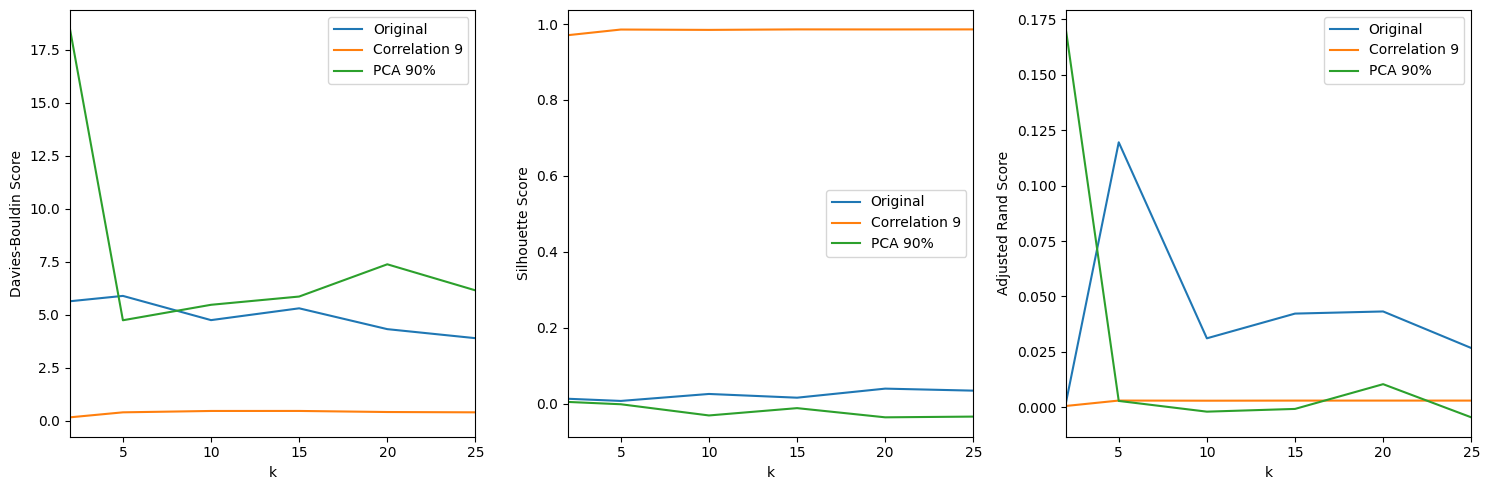

In [30]:
plot_results(ensemble_results, number_clusters)

### Statistical tests

In [31]:
results = {
    'kmeans': kmeans_results,
    'hier_aglo': hier_aglo_results,
    'em': em_results,
    # 'dbscan': dbscan_results,
    'ensemble': ensemble_results
}


results_data = {}

for key in results:
    for item in results[key]:
        results_data[f"{key} - {item[0]}"] = list(item[1][2])

from pprint import pprint

from scipy.stats import friedmanchisquare

friedman_chi2, p_value = friedmanchisquare(*results_data.values())

print("Friedman Chi-squared Statistic:", friedman_chi2)
print("p-value:", p_value)

Friedman Chi-squared Statistic: 31.460641399416897
p-value: 0.0009304129017734295


In [32]:
#!pip install scikit-posthocs

In [33]:
import scikit_posthocs as sp
import numpy as np

# Convert data to matrix form
data_matrix = np.array(list(results_data.values())).T

# # Perform the Nemenyi test
# nemenyi_result = sp.posthoc_nemenyi_friedman(data_matrix)

# heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
# sp.sign_plot(nemenyi_result, **heatmap_args)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7ec818249760>)

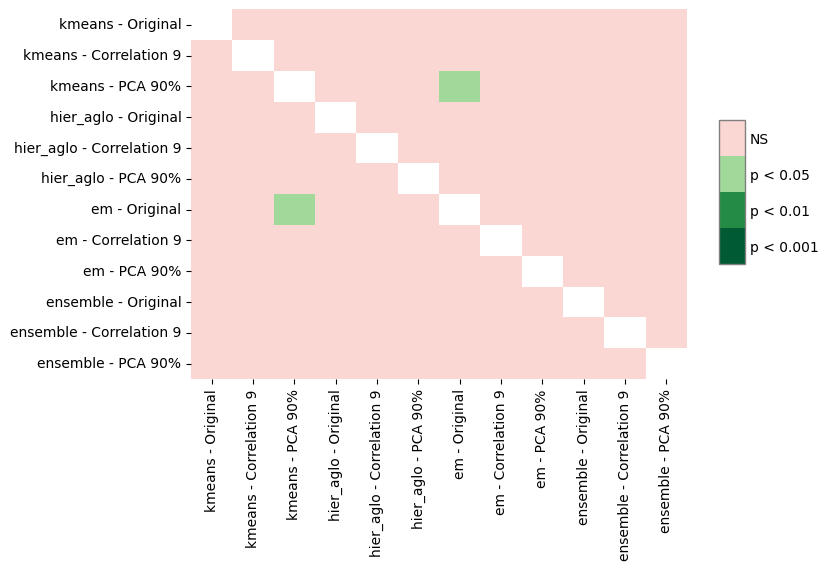

In [34]:
df_data = pd.DataFrame(results_data) \
    .rename_axis('cv_fold') \
    .melt(
        var_name='estimator',
        value_name='score',
        ignore_index=False,
    ) \
    .reset_index()

avg_rank = df_data.groupby('cv_fold').score.rank(pct=True).groupby(df_data.estimator).mean()
avg_rank.head(100)

# Perform the Nemenyi test
nemenyi_result = sp.posthoc_nemenyi_friedman(
    df_data,
    melted=True,
    block_col='cv_fold',
    group_col='estimator',
    y_col='score',
)
sp.sign_plot(nemenyi_result)

/home/iohans/IMD0188-APRENDIZADO_DE_MAQUINA/glpi_venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


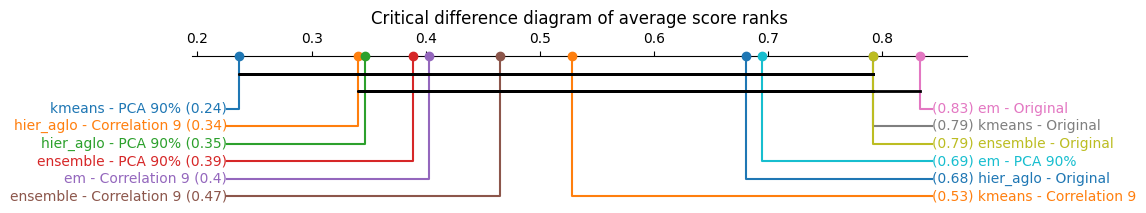

In [35]:
plt.figure(figsize=(10, 2), dpi=100)
plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(avg_rank, nemenyi_result)
plt.show()